# FIFA WC22 Sentiment Analysis

In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


In [ ]:
!pip install pad_sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pad_sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10212 sha256=418b783a7ae3ed822d54ccf4ee8adac3ecb777c66bf3b82f13ad1f83278b2228
  Stored in directory: /root/.cache/pip/wheels/c4/d9/67/a54f34d9d990867c70393d7904a47df2f20f3712c1d246d5f5
Successfully built pad_sequences


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
from gensim.models import Word2Vec


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["Reg", "Date Created", "Number of Likes", "Source of Tweet", "Tweet", "Sentiment", "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

In [ ]:
csv_file_path = "/content/FIFA Dataset.csv"
df = pd.read_csv(csv_file_path, encoding="utf-8", error_bad_lines=False)

<ipython-input-7-8245a08958b7>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(csv_file_path, encoding="utf-8", error_bad_lines=False)


In [ ]:
print("Dataset size:", len(df))

Dataset size: 22524


In [ ]:
df.head(5)

,Reg,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,target
0,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,if the bbc cares so much about human rights h...,negative,0
1,5,2022-11-20 23:57:32+00:00,0,Twitter for Android,and like will the mexican fans be able to scr...,negative,0
2,7,2022-11-20 23:57:05+00:00,0,Twitter for Android,really football on a monday morning at and ...,negative,0
3,10,2022-11-20 23:56:05+00:00,1,Twitter for iPhone,qatar tried to help its useless soccer team ...,negative,0
4,19,2022-11-20 23:52:54+00:00,0,Twitter Web App,aloserslament majstar piersmorgan racist uncu...,negative,0


In [ ]:
print(df.columns)

Index(['Reg', 'Date Created', 'Number of Likes', 'Source of Tweet', 'Tweet',
       'Sentiment', 'target'],
      dtype='object')


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 8.75 ms, sys: 0 ns, total: 8.75 ms
Wall time: 10.5 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

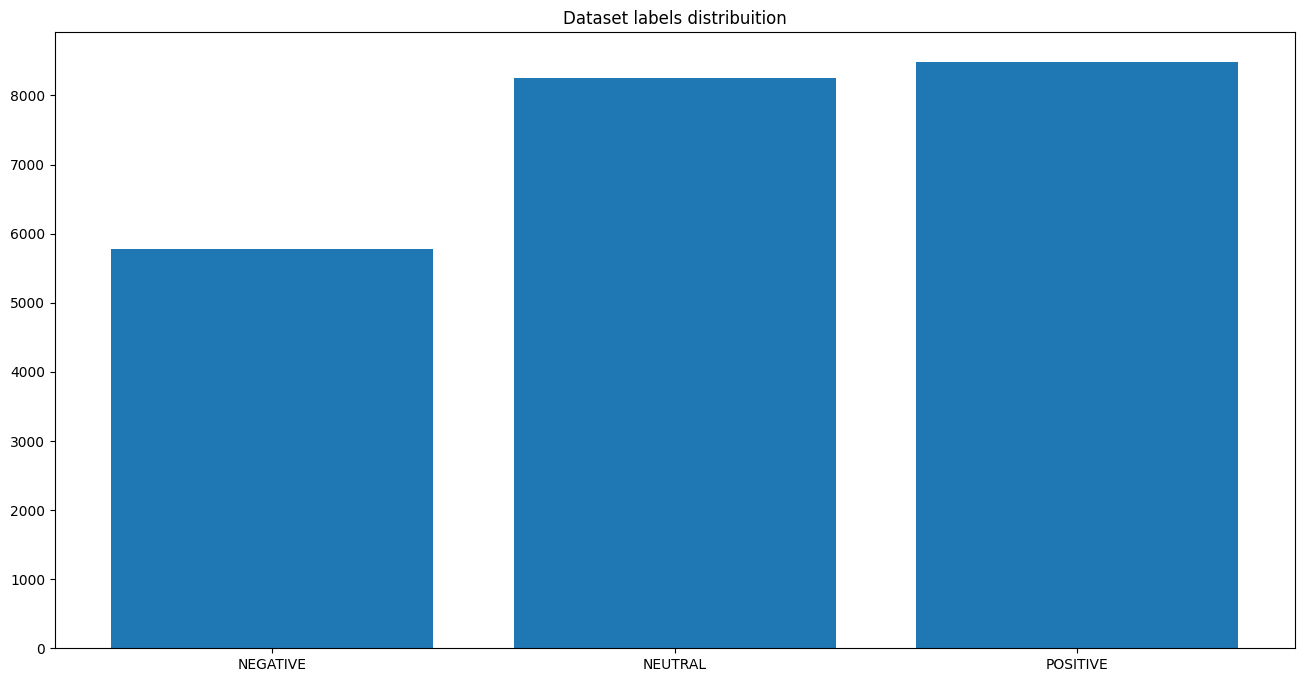

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.Tweet = df.Tweet.apply(lambda x: preprocess(x))

CPU times: user 1.08 s, sys: 3.87 ms, total: 1.08 s
Wall time: 1.24 s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 18019
TEST size: 4505


### Word2Vec 

In [ ]:
%%time
documents = [_text.split() for _text in df_train.Tweet] 

CPU times: user 271 ms, sys: 7.78 ms, total: 278 ms
Wall time: 287 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)


In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2314


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 11.1 s, sys: 140 ms, total: 11.2 s
Wall time: 6.99 s


(4051692, 6863552)

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 20520
CPU times: user 429 ms, sys: 972 µs, total: 430 ms
Wall time: 506 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Tweet), maxlen=SEQUENCE_LENGTH)

CPU times: user 461 ms, sys: 4.85 ms, total: 466 ms
Wall time: 550 ms


### Label Encoder 

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEUTRAL', 'NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (18019, 1)
y_test (4505, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (18019, 300)
y_train (18019, 1)

x_test (4505, 300)
y_test (4505, 1)


In [ ]:
y_train[:10]

array([[1],
       [0],
       [2],
       [1],
       [2],
       [1],
       [0],
       [2],
       [2],
       [2]])

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(20520, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6156000   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6,316,501
Trainable params: 160,501
Non-trainable params: 6,156,000
_________________________________________________________________


### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 170s 9s/step - loss: -0.4081 - accuracy: 0.3744 - val_loss: -1.3649 - val_accuracy: 0.3640 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 140s 9s/step - loss: -2.1791 - accuracy: 0.3852 - val_loss: -2.8776 - val_accuracy: 0.3929 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 138s 9s/step - loss: -3.1532 - accuracy: 0.4096 - val_loss: -3.6519 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 142s 9s/step - loss: -4.1054 - accuracy: 0.4399 - val_loss: -4.2485 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 140s 9s/step - loss: -4.8168 - accuracy: 0.4458 - val_loss: -4.9168 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 135s 8s/step - loss: -5.4381 - accuracy: 0.4416 - val_loss: -5.6219 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 138s 

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

5/5 [==============================] - 9s 2s/step - loss: -11.6671 - accuracy: 0.4446

ACCURACY: 0.4446170926094055
LOSS: -11.667110443115234
CPU times: user 12.9 s, sys: 1.34 s, total: 14.3 s
Wall time: 10.3 s


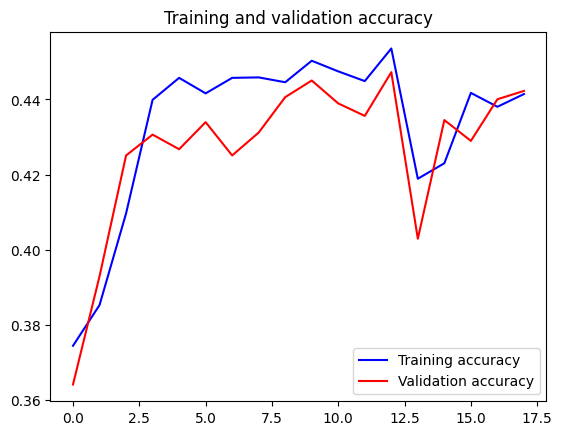

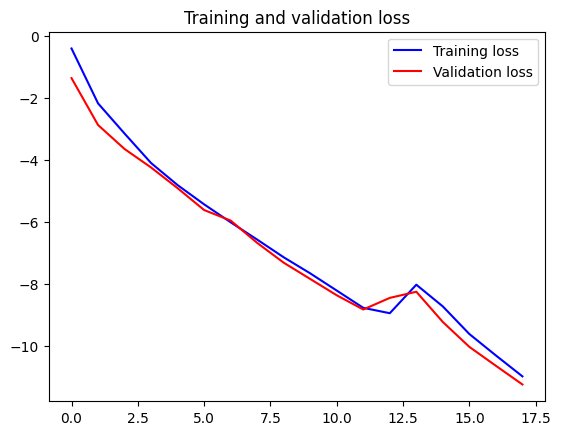

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I hate this music")

1/1 [==============================] - 0s 354ms/step


{'label': 'NEGATIVE',
 'score': 0.05446933954954147,
 'elapsed_time': 0.4043879508972168}

In [ ]:
predict("I love DL Class")

1/1 [==============================] - 0s 53ms/step


{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.10159039497375488}

In [ ]:
predict("I love sleeping")

1/1 [==============================] - 0s 48ms/step


{'label': 'POSITIVE',
 'score': 0.7507256865501404,
 'elapsed_time': 0.09134960174560547}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 11s 11s/step
CPU times: user 13.4 s, sys: 3.98 s, total: 17.4 s
Wall time: 10.8 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

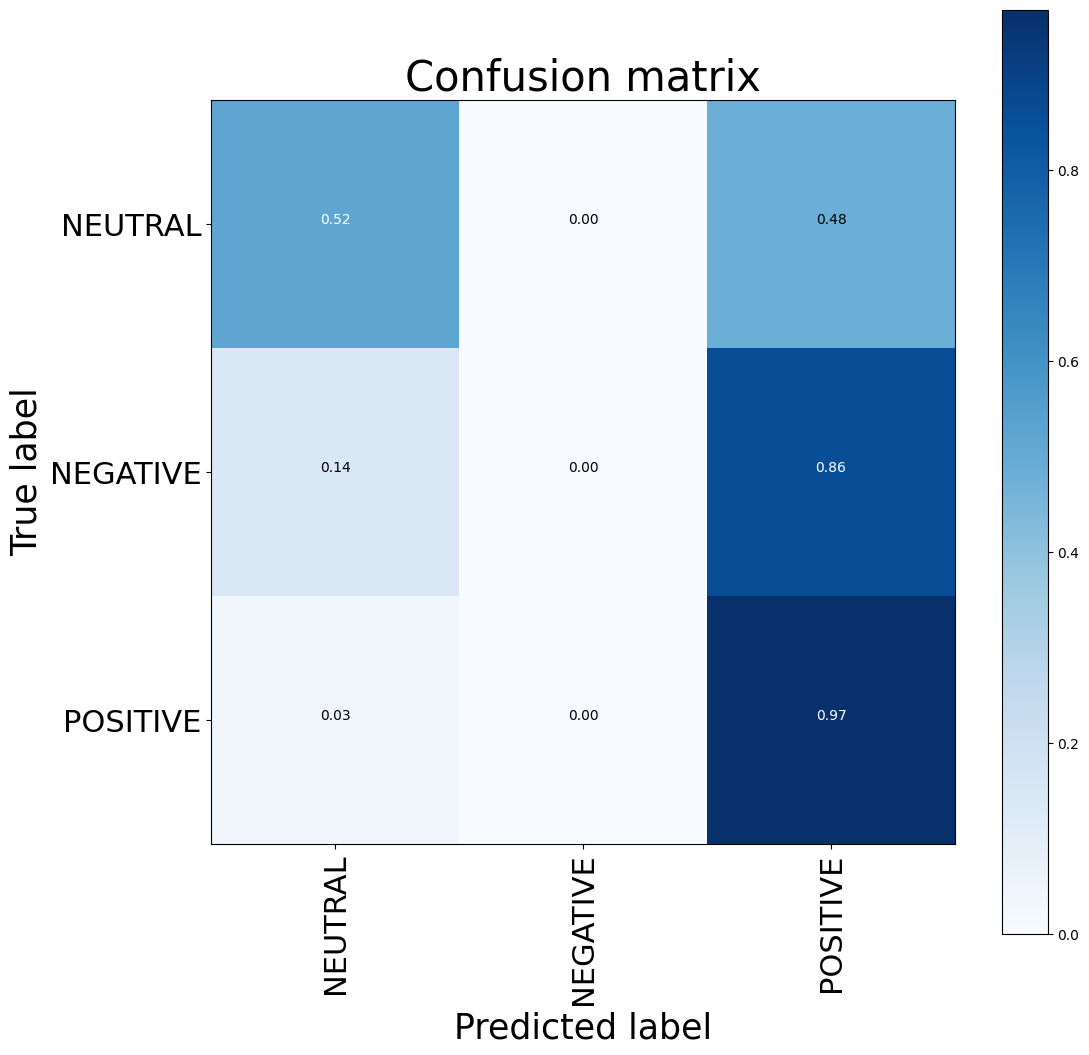

CPU times: user 359 ms, sys: 200 ms, total: 560 ms
Wall time: 330 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.68      0.52      0.59      1167
     NEUTRAL       0.00      0.00      0.00      1628
    POSITIVE       0.46      0.97      0.62      1710

    accuracy                           0.50      4505
   macro avg       0.38      0.50      0.40      4505
weighted avg       0.35      0.50      0.39      4505



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.5018867924528302

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)